# 12. QLS - Linear Regression

It's a technique that measures the relationship between two variables. If we have an independent variable $X$, and a dependent outcome variable $Y$, linear regression will allow us to determine which linear model $Y = \alpha + \beta X$ best explains the data. E.g. let's consider TSLA and SPY. We'd like to know how TSLA varies as a function of how SPY varies, so we'll take the daily returns and regress them against each other.

The `statsmodels` library has a built-in linear fit function. This will give a line of best fit; whether the relationship it shows is significant, is up to us to determine. The output will have some statistics about the model, such as $R^{2}$, and the $F$ value, which might help us quantify how good the fit is.

In [35]:
import numpy as np
import seaborn as sb
from statsmodels import regression
import statsmodels.api as sm
import yfinance as yf

First we'll define a function that performs linear regression and plots the results.

In [36]:
def linreg(x,y):
    # running the linear regression
    x = sm.add_constant(x)
    model = regression.linear_model.OLS(y, x).fit()
    a = model.params[0]
    b = model.params[1]
    x = x[:, 1]

    # return summary of the regression and plot results
    x2 = np.linspace(x.min(), x.max(), 100)
    y_hat = x2 * b + a

    sb.regplot(x=x, y=y).set(xlabel="X Value", ylabel="Y Value");
    return model.summary()

Now we'll get pricing for TSLA and SPY, and perform a regression.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     64.27
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           4.23e-14
Time:                        17:45:47   Log-Likelihood:                 549.18
No. Observations:                 251   AIC:                            -1094.
Df Residuals:                     249   BIC:                            -1087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.532      0.595      -0.002       0.004
x1             1.9541      0.244      8.017      0.000       1.474       2.434
==============================================================================
Omnibus:                       64.854   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.768
Skew:                           0.865   Prob(JB):                     1.53e-82
Kurtosis:                       8.748   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

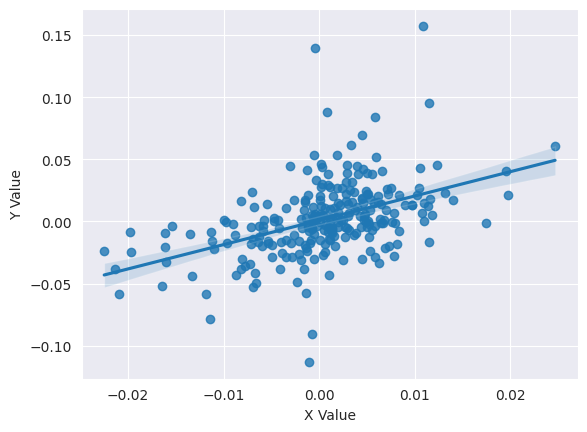

In [37]:
start = "2014-01-01"
end = "2015-01-01"
asset = yf.download("TSLA", start, end)
benchmark = yf.download("SPY", start, end)

# we have to take the %δ to get returns
# we need to get rid of the 0th element because it's NaN
r_a = asset["Adj Close"].pct_change()[1:]
r_b = benchmark["Adj Close"].pct_change()[1:]

linreg(r_b.values, r_a.values)

Each point in the graph above represents a day, with the x-coordinate being the return of SPY, and the y-coordinate the return of TSLA. As we can see, the line of best fit tells us that for every 1% increase in SPY, there's an extra 1.92% from TSLA (expressed by the parameter $\beta$). The same will be true for decreased return, so we haven't gained anything other than volatility.

## Linear Regression vs. Correlation

- Linear regression gives us a specific linear model, but it's limited to cases of linear dependence.
- Correlation is general to linear and non-linear dependencies, but doesn't give us an actual model.
- Both are measures of covariance.
- Linear regression can give us relationships between $Y$ and many independent variables, making $X$ multidimensional.

## Knowing Parameters vs. Estimates

It's very important to keep in mind that all $\alpha$ and $\beta$ parameters estimated by linear regression are just that — estimates. We can't know the underlying true parameters unless we know the physical process producing the data. The parameters we estimate today might not be the same we estimate tomorrow with new data, and the underlying true parameters might be moving. So, it's very important to pay attention to the standard error of the parameter estimates when doing analysis. One way to get a sense of how stable our parameter estimates are is to estimate them using a rolling window of data and see how much variance there is.

E.g. let's see what happens if we regress two purely random variables.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5030
Date:                Wed, 26 Jul 2023   Prob (F-statistic):              0.480
Time:                        17:45:48   Log-Likelihood:                -13.499
No. Observations:                 100   AIC:                             31.00
Df Residuals:                      98   BIC:                             36.21
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4508      0.060      7.571      0.000       0.333       0.569
x1             0.0705      0.099      0.709      0.480      -0.127       0.268
==============================================================================
Omnibus:                       24.819   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                5.359
Skew:                           0.023   Prob(JB):                       0.0686
Kurtosis:                       1.867   Cond. No.                         4.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

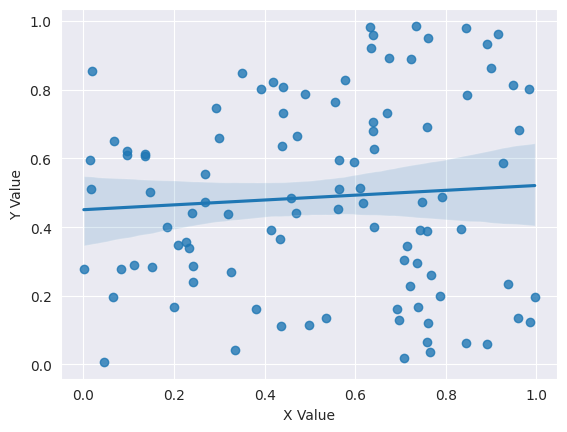

In [38]:
X = np.random.rand(100)
Y = np.random.rand(100)
linreg(X,Y)

The above shows a fairly uniform cloud of points. It's important to note that even with 100 samples, the line has a visible slope due to random chance. This is why it's crucial to use statistical tests and **not** visualizations to verify the results.

Now let's make $Y$ dependent on $X$ plus some noise.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     240.5
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           4.00e-28
Time:                        17:45:48   Log-Likelihood:                 26.869
No. Observations:                 100   AIC:                            -49.74
Df Residuals:                      98   BIC:                            -44.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0067      0.040     -0.169      0.867      -0.086       0.072
x1             1.0298      0.066     15.507      0.000       0.898       1.162
==============================================================================
Omnibus:                        0.792   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.673   Jarque-Bera (JB):                0.423
Skew:                           0.135   Prob(JB):                        0.809
Kurtosis:                       3.170   Cond. No.                         4.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

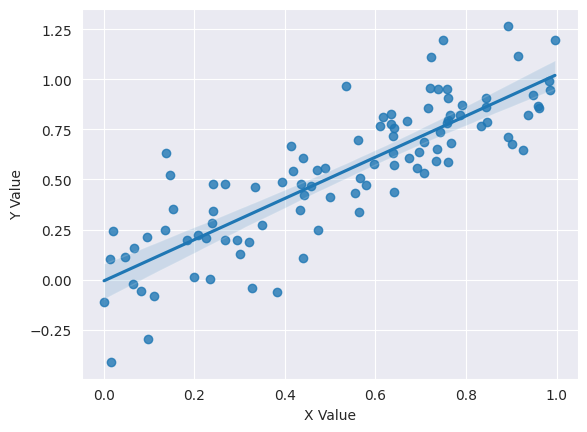

In [39]:
# generate Ys correlated with Xs by adding normally-distributed errors
Y = X + 0.2*np.random.randn(100)

linreg(X,Y)

In a situation like the above, the line of best fit does model the $Y$ variable well (with a high $R^{2}$ value).

## Evaluating & Reporting Results

The regression model relies on several assumptions:

- The independent variable is not random
- The variance of the error term is constant across observations. This is important for evaluating the goodness of the fit.
- The errors are not autocorrelated. The *Durbin-Watson* statistic detects this; if it's close to $2$, there is no autocorrelation.
- The errors are normally distributed. If this does not hold, we cannot use some of the statistics, such as the $F$ value.

If we confirm that the necessary assumptions are satisfied, we can use the statistics reported to analyze the fit. E.g. the $R^{2}$ value tells us the fraction of the total variation of $Y$ that is explained by the model.

When making a prediction based on the model, it's useful to report a confidence interval. The linear regression reports $95$% confidence intervals for the regression parameters.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     64.27
Date:                Wed, 26 Jul 2023   Prob (F-statistic):           4.23e-14
Time:                        17:45:50   Log-Likelihood:                 549.18
No. Observations:                 251   AIC:                            -1094.
Df Residuals:                     249   BIC:                            -1087.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.532      0.595      -0.002       0.004
x1             1.9541      0.244      8.017      0.000       1.474       2.434
==============================================================================
Omnibus:                       64.854   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.768
Skew:                           0.865   Prob(JB):                     1.53e-82
Kurtosis:                       8.748   Cond. No.                         142.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

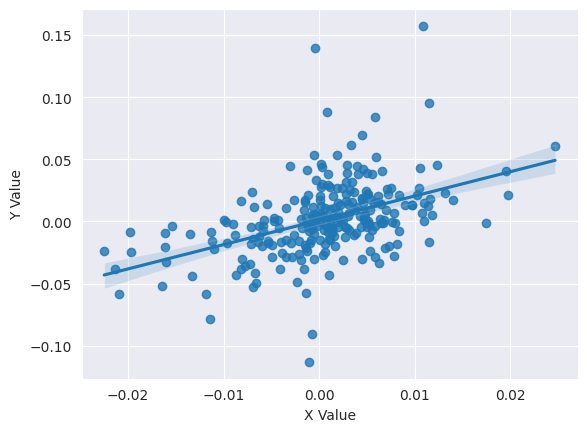

In [40]:
start = "2014-01-01"
end = "2015-01-01"
asset = yf.download("TSLA", start, end)
benchmark = yf.download("SPY", start, end)

# we have to take the %δ to get returns
# we need to get rid of the 0th element because it's NaN
r_a = asset["Adj Close"].pct_change()[1:]
r_b = benchmark["Adj Close"].pct_change()[1:]

linreg(r_b.values, r_a.values)

## Mathematical Background

This is a very brief overview of linear regression. For more, please visit [this](https://en.wikipedia.org/wiki/Linear_regression) site.

### Ordinary Least Squares

Regression works by optimizing the placement of the line of best fit. It does this by defining how bad the fit is using an objective function. In OLS the objective function is:

$$\sum_{i=1}^n (Y_{i} - a - bX_{i})^{2}$$

We use $a$ and $b$ to represent the potential candidates for $\alpha$ and $\beta$. This function means that for each point on the line of best fit, we compare it with the real point and take the square of the difference. This function decreases as we take better parameter estimates. Regression is a simple case of numerical optimization that has a close form solution and does not need any optimizer. We just find the results that minimize the objective function.

We'll denote the eventual model that results from minimizing our objective function as:

$$\hat{Y} = \hat{\alpha} + \hat{\beta}X$$

With $\hat{\alpha}$ and $\hat{\beta}$ being the estimates for the parameters that we use for prediction, and $\hat{Y}$ being the predicted values of $Y$ given the estimates.

### Standard Error

We can also find the standard error of estimates, which measures the standard deviation of the error term $\epsilon$, by getting the `scale` parameter of the model returned by the regression and taking its square root. The formula for standard error of estimate is:

$$s = \left( \frac{\sum_{i=1}^{n} \epsilon_{i}^{2}}{n-2} \right)^{\frac{1}{2}}$$

If $\hat{\alpha}$ and $\hat{\beta}$ were the true parameters $(\hat{\alpha}= \alpha$ and $\hat{\beta}= \beta)$, we could represent the error for a specific value of $Y$ as $s^{2}$ for all values of $X_{i}$. We could simply square the difference $(Y-\hat{Y})$ to get te variance, because $\hat{Y}$ incorporates no error in the parameter estimates themselves. Because $\hat{\alpha}$ and $\hat{\beta}$ are estimates in our construction of model $Y$, any predicted values $\hat{Y}$ will have their own standard error based on the distribution of $X$ terms that we plug into the model. This forecast error is represented by:

$$s_{f}^{2} = s^{2} \left( 1 + \frac{1}{n} + \frac{(X - \mu_{X})^{2}}{(n-1)\sigma_{X}^{2}} \right)$$

Where $\mu_{x}$ is the mean of our observations of $X$ and $\alpha_{x}$ is the standard deviation of $X$. This adjustment to $s^{2}$ incorporates the uncertainty in our parameter estimates. Then the $95$% confidence interval for the prediction is $\hat{Y} \pm t_{c} s_{f}$ where $t_{c}$ is the critical value of the t-statistic for $n$ samples and a desired $95$% confidence.